<a href="https://colab.research.google.com/github/mina26mgl/test/blob/master/train3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from torch.utils.data import DataLoader
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance
from sklearn.preprocessing import LabelEncoder

In [ ]:
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance, ImageFilter

def pre_process_image(img_path):

    img = Image.open(img_path)
    img = img.convert('RGB')
    return img

def _ela_image(path):
    quality=50
    DIR = "temp/"
    TEMP = "temp.jpg"
    ELA_FILENAME = os.path.basename(path).split('.')[0] + '.ela.png'

    # Compute ELA image
    im = Image.open(path).convert('RGB')
    im.save(TEMP, 'JPEG', quality=quality)
    resaved_im = Image.open(TEMP)
    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    # Save ELA image
    if not os.path.isdir(DIR):
         os.mkdir(DIR)
    ela_im.save(os.path.join(DIR, ELA_FILENAME))

    # Return ELA image as numpy array
    return np.array(ela_im)

def _laplacian_image(path):
    threshold=50
    im = Image.open(path).convert('L')
    laplacian_im = im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 8, -1, -1, -1, -1], scale=1))
    laplacian_im = ImageEnhance.Brightness(laplacian_im).enhance(10.0)
    thresholded_im = laplacian_im.point(lambda x: 255 if x > threshold else 0)
    return np.array(thresholded_im)

def _sobel_image(path):
    threshold=50
    im = Image.open(path).convert('L')
    sobel_x = im.filter(ImageFilter.Kernel((3, 3), [-1, 0, 1, -2, 0, 2, -1, 0, 1], scale=1))
    sobel_y = im.filter(ImageFilter.Kernel((3, 3), [-1, -2, -1, 0, 0, 0, 1, 2, 1], scale=1))
    sobel_im = ImageChops.add(sobel_x, sobel_y)
    sobel_im = ImageEnhance.Brightness(sobel_im).enhance(10.0)
    thresholded_im = sobel_im.point(lambda x: 255 if x > threshold else 0)
    return np.array(thresholded_im)


def _canny_image(path):
    low_threshold=50
    high_threshold=150
    im = Image.open(path).convert('L')
    canny_im = im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 8, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.CONTOUR)
    canny_im = canny_im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 0, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 8, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.FIND_EDGES)
    canny_im = ImageEnhance.Brightness(canny_im).enhance(10.0)
    canny_im = canny_im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 0, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 8, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.FIND_EDGES)
    canny_im = canny_im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 0, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.Kernel((3, 3), [-1, -1, -1, -1, 8, -1, -1, -1, -1], scale=1))
    canny_im = canny_im.filter(ImageFilter.FIND_EDGES)
    thresholded_im = canny_im.point(lambda x: 255 if x > low_threshold and x < high_threshold else 0)
    return np.array(thresholded_im)



In [ ]:

dataset = pd.read_csv('C:/Users/HP/Desktop/pfe/python_pfe/dataset.csv')

In [ ]:
X = np.empty((dataset.shape[0], 49152))
Y = []

In [ ]:
X = np.zeros((len(dataset), 128 * 128 * 3))
Y = []

for i, row in dataset.iterrows():
    img = pre_process_image(row[0])
    if img is not None:
        img_resized = img.resize((128, 128))
        img_arr = np.array(img_resized).flatten() / 255.0
        X[i] = img_arr
        Y.append(row[1])

Y = np.array(Y)


In [ ]:
for index, row in dataset.iterrows():

    x = array(pre_process_image(row[0]).resize((128, 128))).flatten() / 255.0
    X = np.concatenate((X, [x]))
    Y = np.concatenate((Y, [row[1]]))
print(X)
print(Y)

[[0.25490196 0.30588235 0.35294118 ... 0.64313725 0.64313725 0.60392157]
 [0.04705882 0.07058824 0.10980392 ... 0.39215686 0.45882353 0.52156863]
 [0.60392157 0.60784314 0.62352941 ... 0.54117647 0.51764706 0.46666667]
 ...
 [0.63137255 0.62745098 0.63529412 ... 0.49019608 0.48235294 0.45490196]
 [0.85098039 0.86666667 0.86666667 ... 0.39607843 0.41568627 0.41176471]
 [0.82352941 0.78823529 0.71764706 ... 0.36078431 0.36862745 0.35686275]]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
X = X.reshape(-1, 128, 128, 3)
X = np.array(X).reshape(-1, 128, 128, 3)

Y = np.array(Y).flatten()
print(X.shape)
print(Y.shape)

(214, 128, 128, 3)
(214,)


In [ ]:
from sklearn.model_selection import train_test_split

# X contient vos données d'images et y contient les labels correspondants
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, random_state=42)




In [ ]:
encoder = LabelEncoder()
Y_train = to_categorical(encoder.fit_transform(Y_train))
Y_val = to_categorical(encoder.transform(Y_val))
print(X_train.shape)
print(Y_train.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)

(153, 128, 128, 3)
(153, 2)
(39, 2)
(22, 128, 128, 3)
(22,)
(39, 128, 128, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten
from keras.layers import Dense
# from keras.activations import sigmoid


model = Sequential()


model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))

print(X_train.shape)


(153, 128, 128, 3)


In [ ]:
model.summary()
print(X_train.shape)
print(Y_train.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)


In [ ]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

print(X_train.shape)

(153, 128, 128, 3)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
print(X_train.shape)

(153, 128, 128, 3)


In [ ]:
epochs = 10
batch_size = 16
print(X_train.shape)
print(Y_test.shape)

(153, 128, 128, 3)
(22,)


In [ ]:

print(Y_test.shape)
# Modifier les dimensions des labels
Y_test = to_categorical(Y_test, num_classes=2)
print(Y_test.shape)

(22,)
(22, 2)


In [ ]:
print(Y_train.shape)
print(X_train.shape)

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, shuffle=True,
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

(153, 2)
(153, 128, 128, 3)
Epoch 1/10
10/10 - 9s - loss: 0.5491 - accuracy: 0.7843 - val_loss: 0.7163 - val_accuracy: 0.6923 - 9s/epoch - 941ms/step
Epoch 2/10
10/10 - 6s - loss: 0.4472 - accuracy: 0.8039 - val_loss: 0.5442 - val_accuracy: 0.6923 - 6s/epoch - 572ms/step
Epoch 3/10
10/10 - 5s - loss: 0.4214 - accuracy: 0.8039 - val_loss: 0.4324 - val_accuracy: 0.6923 - 5s/epoch - 483ms/step
Epoch 4/10
10/10 - 5s - loss: 0.3113 - accuracy: 0.8301 - val_loss: 0.2972 - val_accuracy: 0.8974 - 5s/epoch - 488ms/step
Epoch 5/10
10/10 - 5s - loss: 0.1842 - accuracy: 0.9542 - val_loss: 0.2681 - val_accuracy: 0.9231 - 5s/epoch - 496ms/step
Epoch 6/10
10/10 - 5s - loss: 0.1929 - accuracy: 0.9608 - val_loss: 0.2909 - val_accuracy: 0.8205 - 5s/epoch - 515ms/step
Epoch 7/10
10/10 - 4s - loss: 0.1705 - accuracy: 0.9150 - val_loss: 0.1954 - val_accuracy: 0.9744 - 4s/epoch - 444ms/step
Epoch 8/10
10/10 - 5s - loss: 0.1167 - accuracy: 0.9673 - val_loss: 0.1085 - val_accuracy: 0.9744 - 5s/epoch - 465ms/s

In [ ]:
print(X_test.shape)
print(Y_test.shape)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy sur l\'ensemble de test:', test_acc)


(22, 128, 128, 3)
(22, 2)
Accuracy sur l'ensemble de test: 1.0


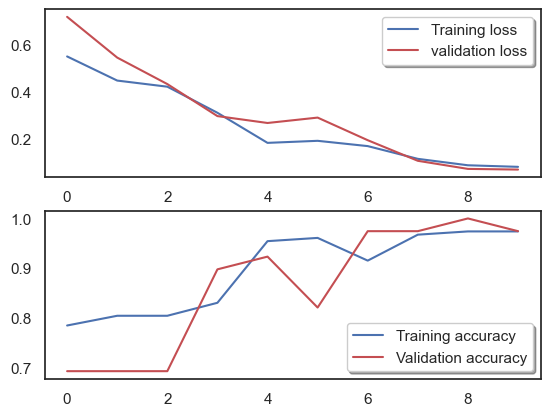

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
import cloudinary
import cloudinary.uploader
import cloudinary.api

# Configurer votre compte Cloudinary
cloudinary.config(
  cloud_name="dyrmruoan",
  api_key="418341411657696",
  api_secret="UVhtMxBnAnZ2_VL5aupvlnTpAjM",

)

# Uploadez votre image sur Cloudinary
upload_result = cloudinary.uploader.upload("C:/Users/HP/Desktop/pfe/img/dataset/p23.jpg")

# Récupérer l'URL de l'image que vous avez uploadée
image_url = upload_result["url"]

print(image_url)



http://res.cloudinary.com/dyrmruoan/image/upload/v1683931466/znzpon0ekmt1vyhdwxqi.jpg


In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np

import socket
s = socket.socket()
s.connect(('www.google.com', 8080))

# Télécharger l'image depuis l'URL
response = requests.get(image_url)
print(response.status_code)

img = Image.open(BytesIO(response.content))
if img.mode != "RGB":
    # Convertir l'image en RGB
    img = img.convert("RGB")
# Redimensionner l'image
img = img.resize((128, 128))


# Convertir l'image en tableau numpy
image_array = np.array(img) / 255.0
image_array = np.expand_dims(image_array, axis=0)


TimeoutError: [WinError 10060] Une tentative de connexion a échoué car le parti connecté n’a pas répondu convenablement au-delà d’une certaine durée ou une connexion établie a échoué car l’hôte de connexion n’a pas répondu

In [ ]:
model.save("C:/Users/HP/Desktop/pfe/python_pfe/model_c2.h5" )

In [ ]:
from PIL import Image
import numpy as np

# Load the image
img = Image.open("C:/Users/HP/Desktop/pfe/img/dataset/image10.jpg")
# Vérifier le mode de l'image
if img.mode != "RGB":
    # Convertir l'image en RGB
    img = img.convert("RGB")
# Resize the image to 128x128
img_resized = img.resize((128, 128))

# Convert the image to a numpy array
img_arr = np.array(img_resized) / 255.0

# Add an extra dimension to match the expected shape of the input
img_arr = np.expand_dims(img_arr, axis=0)

print(img_arr.shape)
# Make the prediction
prediction = model.predict(img_arr)
print(prediction)
if prediction[0][0] < 0.5:
    print("L'image est falsifiée.")
else:
    print("L'image est authentique.")



(1, 128, 128, 3)
1/1 [==============================] - 0s 356ms/step
[[0.3285697 0.6714303]]
L'image est falsifiée.
